In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import urllib.parse
from scipy.stats import linregress
from api_keys import omdb_api_key
from pprint import pprint


#print(omdb_api_key)

# Sets the path to our movie csv file
path = 'Resources/boxoffice.csv'

In [2]:
# Pulls in a list of ~16000 top movies of all time
top_boxoffice_df = pd.read_csv(path)

# Drops the maunally created index column
top_boxoffice_df.drop(labels=['index'], axis=1, inplace=True)

top_boxoffice_df

,rank,title,studio,lifetime_gross,year
0,1,Star Wars: Episode VII,BV,936662225,2015
1,2,Avengers: Endgame,BV,857190335,2019
2,3,Avatar,Fox,760507625,2009
3,4,Black Panther,BV,700059566,2018
4,5,Avengers: Infinity War,BV,678815482,2018
...,...,...,...,...,...
16537,16538,Dog Eat Dog,IFC,80,2009
16538,16539,Paranoid Girls,NaN,78,2015
16539,16540,Confession of a Child of the Century,Cohen,74,2015
16540,16541,Storage 24,Magn.,72,2013


In [3]:
# Creates a dataframe for the top 1000 movies
top1k_boxoffice_df = pd.read_csv(path, nrows = 1000)

# Drops the maunally created index column
top1k_boxoffice_df.drop(labels=['index'], axis=1, inplace=True)

top1k_boxoffice_df

,rank,title,studio,lifetime_gross,year
0,1,Star Wars: Episode VII,BV,936662225,2015
1,2,Avengers: Endgame,BV,857190335,2019
2,3,Avatar,Fox,760507625,2009
3,4,Black Panther,BV,700059566,2018
4,5,Avengers: Infinity War,BV,678815482,2018
...,...,...,...,...,...
995,996,City of Angels,WB,78685114,1998
996,997,The English Patient,Mira.,78676425,1996
997,998,Teenage Mutant Ninja Turtles II,NL,78656813,1991
998,999,A.I. Artificial Intelligence,WB,78616689,2001


In [4]:
# Creates a dataframe for the bottom 1000 movies
bot1k_boxoffice_df = pd.read_csv(path, skiprows= 15542, nrows = 1001, names=['rank', 'title', 'studio', 'lifetime_gross', 'year'])

bot1k_boxoffice_df

,rank,title,studio,lifetime_gross,year
15541,15542,December,IRS,5868,1991
15542,15543,Buzzkill,Indic.,5860,2012
15543,15544,Gaudi Afternoon,Cn4,5858,2003
15544,15545,Top Spin,FRun,5858,2015
15545,15546,The Work,Orch.,5853,2017
...,...,...,...,...,...
16537,16538,Dog Eat Dog,IFC,80,2009
16538,16539,Paranoid Girls,NaN,78,2015
16539,16540,Confession of a Child of the Century,Cohen,74,2015
16540,16541,Storage 24,Magn.,72,2013


In [ ]:
# Creates a list of all of the movie titles in the top 1k movies from the dataframe
movies_list = top1k_boxoffice_df['title'].tolist()

# Creates empty lists for all of the information we want from the json requests
req_imdbID = []
req_titles = []
req_studio = []
req_boxoffice = []
req_runtime = []
req_age_rating = []
req_release_date = []
req_country = []
req_genre = []
req_imdb_rating = []
req_imdb_votecount = []
req_critic_rating = []
req_directors = []

print('Beginning OMDb data retriveal:')
print('______________________________')

try:
    
    # Loops through the dataframe and pulls the rest of  the information for the movies from OMDb API
    for movie_title in movies_list:

        # Encodes the entire movie title to account for characters
        encoded_title = urllib.parse.quote(movie_title)

        # Sets the base url for OMDb API and prints it out, comment out the printing function if using in public
        omdb_url = f'http://www.omdbapi.com/?t={encoded_title}&apikey={omdb_api_key}'
        print(f"API Request URL: {omdb_url}")

        # Creates a request to the OMDb API
        response = requests.get(omdb_url)
        request = response.json()

        # Tells us what is wrong with a request if it is not good
        if response.status_code != 200 or request['Response'] == 'False':
            print(f"Failed to retrieve movie '{movie_title}' from OMDb API.")
            print(f"Response: {request}")
            continue

        # Skips tv series from the data set
        if request['Type'] == 'series':
            print(f"'{movie_title}' is a TV series. Skipping...")
            continue

        # Gets the studio of each movie when it loops through the list
        studio_info = top1k_boxoffice_df.loc[top1k_boxoffice_df['title'] == movie_title, 'studio'].values[0]

        # Adds the information of each title to each list
        req_imdbID.append(request['imdbID'])
        req_titles.append(request['Title'])
        req_studio.append(studio_info)
        req_boxoffice.append(request['BoxOffice'])
        req_runtime.append(request['Runtime'])
        req_age_rating.append(request['Rated'])
        req_release_date.append(request['Released'])
        req_country.append(request['Country'])
        req_genre.append(request['Genre'])
        req_imdb_rating.append(request['imdbRating'])
        req_imdb_votecount.append(request['imdbVotes'])
        req_critic_rating.append(request['Metascore'])
        req_directors.append(request['Director'])

# Prints any errors that occured
except Exception as e:    
    print('An error occurred:', str(e))

print('______________________________')
print('Data retrieval complete')

    

In [6]:
# Creates our usable dataframe for our movies
total_movie_df = pd.DataFrame({
    'IMDb ID': req_imdbID,
    'Movie Title': req_titles,
    'Studio': req_studio,
    'Box Office Sales': req_boxoffice,
    'Movie Runtime': req_runtime,
    'Age Rating': req_age_rating,
    'Release Date' : req_release_date,
    'Country' : req_country,
    'Genre': req_genre,
    'IMDb Rating' :  [float(rating) if rating != 'N/A' else np.nan for rating in req_imdb_rating],
    'IMDb Vote Count' : req_imdb_votecount,
    'Critic Rating' : [float(rating) / 10 if rating != 'N/A' else np.nan for rating in req_critic_rating],
    'Director(s)' : req_directors,
})

total_movie_df.to_excel('Resources/totalmoviedf.xlsx')

total_movie_df

,IMDb ID,Movie Title,Studio,Box Office Sales,Movie Runtime,Age Rating,Release Date,Country,Genre,IMDb Rating,IMDb Vote Count,Critic Rating,Director(s)
0,tt2488496,Star Wars: Episode VII - The Force Awakens,BV,"$936,662,225",138 min,PG-13,18 Dec 2015,United States,"Action, Adventure, Sci-Fi",7.8,"945,099",8.0,J.J. Abrams
1,tt4154796,Avengers: Endgame,BV,"$858,373,000",181 min,PG-13,26 Apr 2019,United States,"Action, Adventure, Drama",8.4,"1,172,062",7.8,"Anthony Russo, Joe Russo"
2,tt0499549,Avatar,Fox,"$785,221,649",162 min,PG-13,18 Dec 2009,United States,"Action, Adventure, Fantasy",7.9,"1,338,789",8.3,James Cameron
3,tt1825683,Black Panther,BV,"$700,426,566",134 min,PG-13,16 Feb 2018,United States,"Action, Adventure, Sci-Fi",7.3,"798,824",8.8,Ryan Coogler
4,tt4154756,Avengers: Infinity War,BV,"$678,815,482",149 min,PG-13,27 Apr 2018,United States,"Action, Adventure, Sci-Fi",8.4,"1,116,082",6.8,"Anthony Russo, Joe Russo"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
967,tt0120632,City of Angels,WB,"$78,685,114",114 min,PG-13,10 Apr 1998,"United States, Germany","Drama, Fantasy, Romance",6.7,"123,806",5.4,Brad Silberling
968,tt0116209,The English Patient,Mira.,"$78,676,425",162 min,R,06 Dec 1996,"United States, United Kingdom","Drama, Romance, War",7.4,"194,715",8.7,Anthony Minghella
969,tt0103060,Teenage Mutant Ninja Turtles II: The Secret of...,NL,"$78,656,813",88 min,PG,22 Mar 1991,"Hong Kong, United States","Action, Adventure, Comedy",6.0,"57,832",4.5,Michael Pressman
970,tt0212720,A.I. Artificial Intelligence,WB,"$78,616,689",146 min,PG-13,29 Jun 2001,"United States, United Kingdom","Drama, Sci-Fi",7.2,"314,145",6.5,Steven Spielberg


In [7]:
# Condenses the studio names for each movie in the top 1000 to make graphing easier
def studio_merge(name):
    if 'AIP' in name:
        return 'Other'
    elif 'AVCO' in name:
        return 'Other'
    elif 'Art.' in name:
        return 'Other'
    elif 'BV' in name:
        return 'Disney'
    elif 'Col.' in name:
        return 'Columbia'
    elif 'DW' in name:
        return 'Dreamworks'
    elif 'Dim.' in name:
        return 'Other'
    elif 'Dis.' in name:
        return 'Disney'
    elif 'FD' in name:
        return 'Other'
    elif 'Focus' in name:
        return 'Other'
    elif 'FoxS' in name:
        return 'Fox'
    elif 'LG/S' in name:
        return 'Lionsgate'
    elif 'LGF' in name:
        return 'Lionsgate'
    elif 'Lions' in name:
        return 'Lionsgate'
    elif 'MFF' in name:
        return 'Universal'
    elif 'Mira.' in name:
        return 'MiraMax'
    elif 'NL' in name:
        return 'New Line'
    elif 'NM' in name:
        return 'Other'
    elif 'Orion' in name:
        return 'Other'
    elif 'P/DW' in name:
        return 'Dreamworks'
    elif 'Par.' in name:
        return 'Paramount'
    elif 'RAtt.' in name:
        return 'Other'
    elif 'RKO' in name:
        return 'Other'
    elif 'Rela.' in name:
        return 'Other'
    elif 'SGem' in name:
        return 'Other'
    elif 'SPC' in name:
        return 'Other'
    elif 'SonR' in name:
        return 'Sony'
    elif 'Sum.' in name:
        return 'Summit'
    elif 'TriS' in name:
        return 'Tristar'
    elif 'UA' in name:
        return 'United Artists'
    elif 'USA' in name:
        return 'Other'
    elif 'Uni.' in name:
        return 'Universal'
    elif 'W/Dim.' in name:
        return 'Other'
    elif 'WB' in name:
        return 'Warner Brothers'
    elif 'WB (NL)' in name:
        return 'Warner Brothers'
    elif 'Wein.' in name:
        return 'Other'
    
total_movie_df['Studio'] = total_movie_df['Studio'].apply(studio_merge)

total_movie_df

,IMDb ID,Movie Title,Studio,Box Office Sales,Movie Runtime,Age Rating,Release Date,Country,Genre,IMDb Rating,IMDb Vote Count,Critic Rating,Director(s)
0,tt2488496,Star Wars: Episode VII - The Force Awakens,Disney,"$936,662,225",138 min,PG-13,18 Dec 2015,United States,"Action, Adventure, Sci-Fi",7.8,"945,099",8.0,J.J. Abrams
1,tt4154796,Avengers: Endgame,Disney,"$858,373,000",181 min,PG-13,26 Apr 2019,United States,"Action, Adventure, Drama",8.4,"1,172,062",7.8,"Anthony Russo, Joe Russo"
2,tt0499549,Avatar,None,"$785,221,649",162 min,PG-13,18 Dec 2009,United States,"Action, Adventure, Fantasy",7.9,"1,338,789",8.3,James Cameron
3,tt1825683,Black Panther,Disney,"$700,426,566",134 min,PG-13,16 Feb 2018,United States,"Action, Adventure, Sci-Fi",7.3,"798,824",8.8,Ryan Coogler
4,tt4154756,Avengers: Infinity War,Disney,"$678,815,482",149 min,PG-13,27 Apr 2018,United States,"Action, Adventure, Sci-Fi",8.4,"1,116,082",6.8,"Anthony Russo, Joe Russo"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
967,tt0120632,City of Angels,Warner Brothers,"$78,685,114",114 min,PG-13,10 Apr 1998,"United States, Germany","Drama, Fantasy, Romance",6.7,"123,806",5.4,Brad Silberling
968,tt0116209,The English Patient,MiraMax,"$78,676,425",162 min,R,06 Dec 1996,"United States, United Kingdom","Drama, Romance, War",7.4,"194,715",8.7,Anthony Minghella
969,tt0103060,Teenage Mutant Ninja Turtles II: The Secret of...,New Line,"$78,656,813",88 min,PG,22 Mar 1991,"Hong Kong, United States","Action, Adventure, Comedy",6.0,"57,832",4.5,Michael Pressman
970,tt0212720,A.I. Artificial Intelligence,Warner Brothers,"$78,616,689",146 min,PG-13,29 Jun 2001,"United States, United Kingdom","Drama, Sci-Fi",7.2,"314,145",6.5,Steven Spielberg


The r-value is: 0.7677881436191905


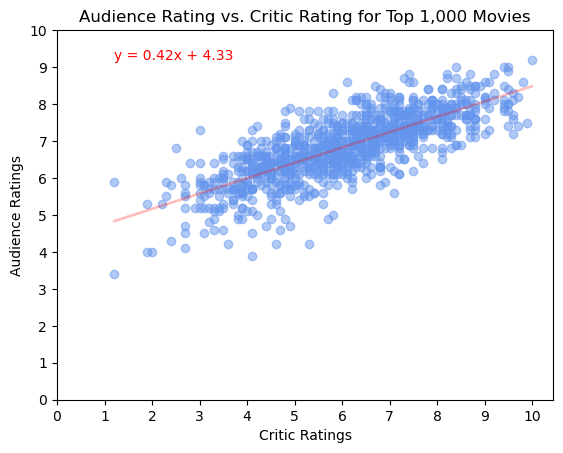

In [8]:
# Drops any NA values in the ratings colums so we can plot it better
total_movie_df = total_movie_df.dropna(subset=['Critic Rating', 'IMDb Rating'])

# Scatter plot for each movie
scatter = plt.scatter(x=total_movie_df['Critic Rating'], y=total_movie_df['IMDb Rating'], c='cornflowerblue', alpha=.5)

# Creates a title and axes titles for the graph
plt.title('Audience Rating vs. Critic Rating for Top 1,000 Movies')
plt.xlabel('Critic Ratings')
plt.ylabel('Audience Ratings')

# Creates the regression line and plots it along with the r-value
(slope, intercept, rvalue, pvalue, stderr) = linregress(total_movie_df['Critic Rating'], total_movie_df['IMDb Rating'])
regress_line = slope * total_movie_df['Critic Rating'] + intercept
linregress_equation = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.plot(total_movie_df['Critic Rating'], regress_line, color='r', alpha=.25)
plt.text(total_movie_df['Critic Rating'].min(), total_movie_df['IMDb Rating'].max(), linregress_equation, color='red',)
 
print(f"The r-value is: {rvalue}")

# Sets the limit on the x and y axis
plt.xticks(range(0,11))
plt.yticks(range(0,11))

plt.show()

C:\Users\Jesse\AppData\Local\Temp\ipykernel_13396\1690782614.py:2: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



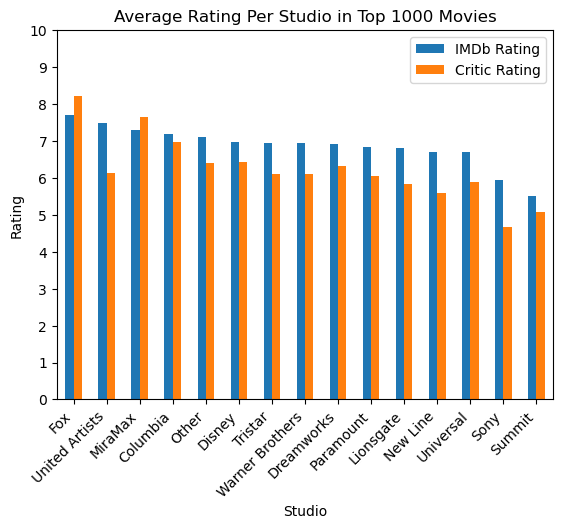

In [10]:
# Groups the movies by studio and gets the average rating per studio
studio_group_df = total_movie_df.groupby('Studio').mean()
sorted_studio_group_df = studio_group_df.sort_values(by='IMDb Rating', ascending=False)

# Bar graph for each studio and rating
sorted_studio_group_df.plot(kind='bar', align='center')

# Adds axis titles and graph title
plt.title('Average Rating Per Studio in Top 1000 Movies')
plt.xlabel('Studio')
plt.ylabel('Rating')

# Adjusts the presentation of the x axis
plt.yticks(range(0,11))
plt.xticks(rotation=45, ha='right')
plt.show()